In [68]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from datetime import datetime, timedelta

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

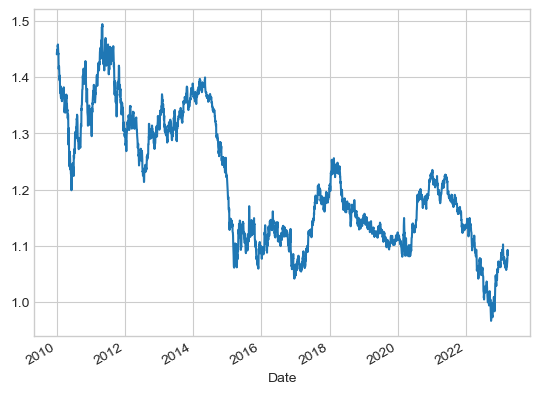

In [69]:
data = yf.download('EURUSD=X', start='2010-01-01', end='2023-03-25')
data.columns = map(str.lower, data.columns)
data = data.drop('volume', axis=1)
data = data.drop('adj close', axis=1)

data.high.plot()

In [70]:
nb_jour_prev = 1
nb_jour_prev = -nb_jour_prev + 1
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    # df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
                                       
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_90'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close'].shift(nb_jour_prev)
    df_new = df_new.dropna(axis=0)
    return df_new

data_feat = generate_features(data)

### SEGREGATING TRAIN AND TEST DATA

In [71]:
#import datetime module
import datetime

#segregate data for training
end_train = datetime.datetime(2022, 5, 1, 0, 0)
data_train = data_feat.loc[:end_train]
data_test = data_feat.loc[end_train+timedelta(days=1):]

X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2958, 33), (235, 33), (2958,), (235,))

### SCALING THE PREDICTOR DATA

In [75]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(data_feat.drop('close', axis='columns'))

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [96]:
X_test["close_1"].shift()

Date
2022-05-02         NaN
2022-05-03    1.050420
2022-05-04    1.053596
2022-05-05    1.050906
2022-05-06    1.052853
                ...   
2023-03-20    1.058335
2023-03-21    1.061413
2023-03-22    1.067886
2023-03-23    1.071915
2023-03-24    1.077424
Name: close_1, Length: 235, dtype: float64

In [95]:
y_test

Date
2022-05-02    1.053596
2022-05-03    1.050906
2022-05-04    1.052853
2022-05-05    1.062248
2022-05-06    1.053974
                ...   
2023-03-20    1.067886
2023-03-21    1.071915
2023-03-22    1.077424
2023-03-23    1.087039
2023-03-24    1.083506
Name: close, Length: 235, dtype: float64

In [80]:
def show_evolution(prediction, model_name):
    evolution_df = pd.DataFrame();
    evolution_df["evolution_test_y"] = (y_test - X_test["close_1"].shift(-nb_jour_prev)).values
    evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift(-nb_jour_prev)).values
    evolution_df = evolution_df[evolution_df['evolution_prediction'] > -0.2]
    # true_data = yf.download('EURUSD=X', start='2022-12-02', end='2023-03-01');
    #evolution_df["evolution_test_y"] = true_data.Close - true_data.Close.shift()
    #evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift()).values
    evolution_df["ligne"] = 0;

    evolution_df = evolution_df.dropna().sort_values('evolution_test_y', ascending=False)

    plt.figure(figsize = (18,9))
    plt.style.use('seaborn-whitegrid')
    plot_truth, = plt.plot(evolution_df["evolution_test_y"].values)
    plot_lin, = plt.plot(evolution_df["evolution_prediction"].values)
    plot_ligne, = plt.plot(evolution_df["ligne"].values)

    plt.legend([plot_truth, plot_lin, plot_ligne], ['Truth', model_name, '0'])
    plt.title('Price evolution : Prediction vs Truth - '+model_name)
    plt.show()

### LINEAR REGRESSION (LIN)

In [46]:
# X_scaled_test = X_scaled_train
# y_test = y_train
# X_test = X_train
# data_test = data_train

In [78]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)


y_metric = y_test.shift(nb_jour_prev).dropna()
predic_metric = predictions_lin[0:nb_jour_prev] if nb_jour_prev != 0 else predictions_lin

print('RMSE: {0:.3f}'.format(mean_squared_error(y_metric, predic_metric)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_metric, predic_metric)))
print('R^2: {0:.3f}'.format(r2_score(y_metric, predic_metric)))

bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

RMSE: 0.005
MAE: 0.003
R^2: 0.982
OOB: 1.000
RMSE: 0.004
MAE: 0.003
R^2: 0.985


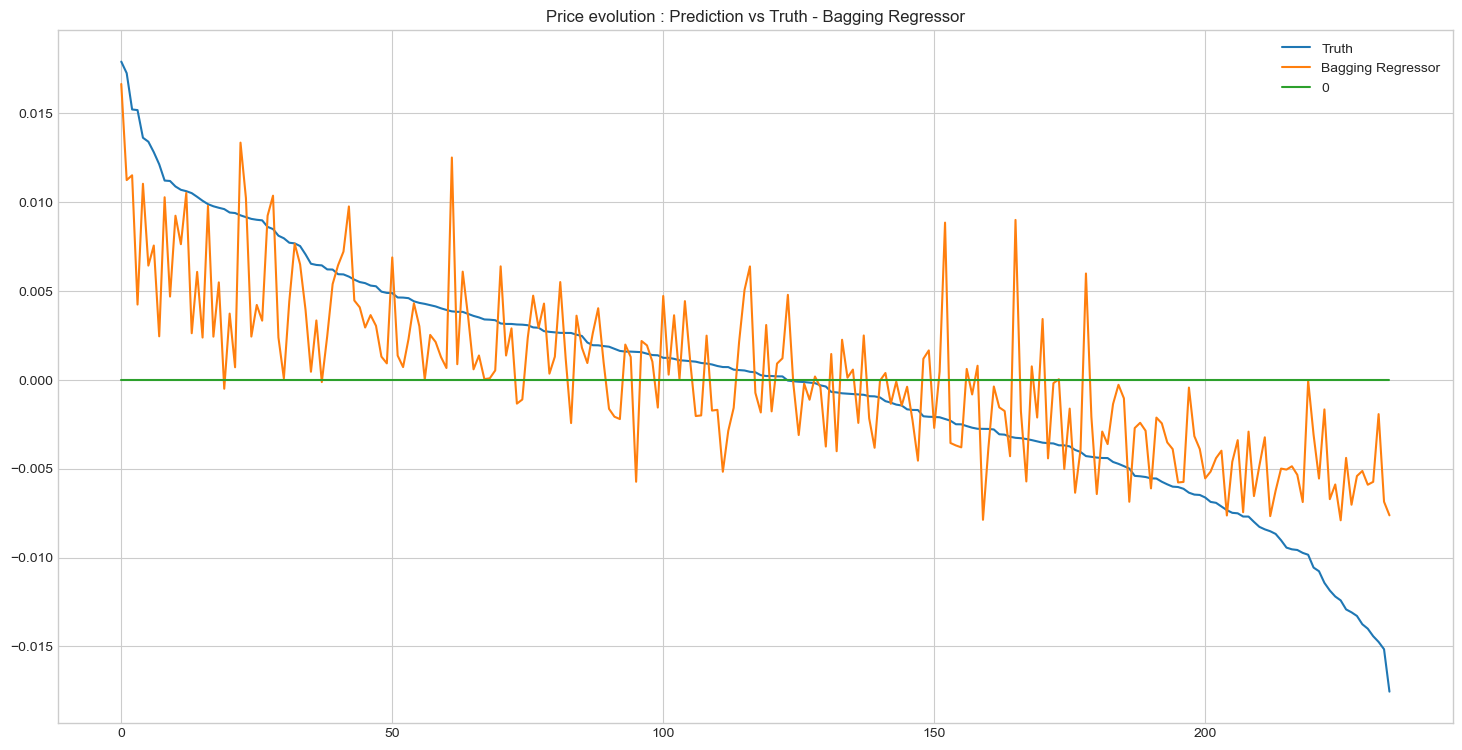

In [81]:
show_evolution(predictions_bgr, 'Bagging Regressor')

In [27]:
def show_evolution2(prediction, prediction2, model_name):
    evolution_df = pd.DataFrame();
    evolution_df["evolution_test_y"] = (y_test - X_test["close_1"].shift(-nb_jour_prev)).values
    evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift(-nb_jour_prev)).values
    evolution_df["evolution_prediction2"] = (prediction2 - X_test["close_1"].shift(-nb_jour_prev)).values
    # true_data = yf.download('EURUSD=X', start='2022-12-02', end='2023-03-01');
    #evolution_df["evolution_test_y"] = true_data.Close - true_data.Close.shift()
    #evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift()).values
    evolution_df = evolution_df[evolution_df['evolution_prediction2'] > -0.2]
    print (evolution_df['evolution_prediction2'].quantile(0.000000001))
    evolution_df = evolution_df.dropna().sort_values('evolution_test_y', ascending=False)

    plt.figure(figsize = (18,9))
    plt.style.use('seaborn-whitegrid')
    plot_truth, = plt.plot(evolution_df["evolution_test_y"].values)
    plot_lin, = plt.plot(evolution_df["evolution_prediction"].values)
    plot_pred2, = plt.plot(evolution_df["evolution_prediction2"].values)

    plt.legend([plot_truth, plot_lin, plot_pred2], ['Truth', model_name, 'pred2'])
    plt.title('Price evolution : Prediction vs Truth - '+model_name)
    plt.show()

-0.00845748785130792


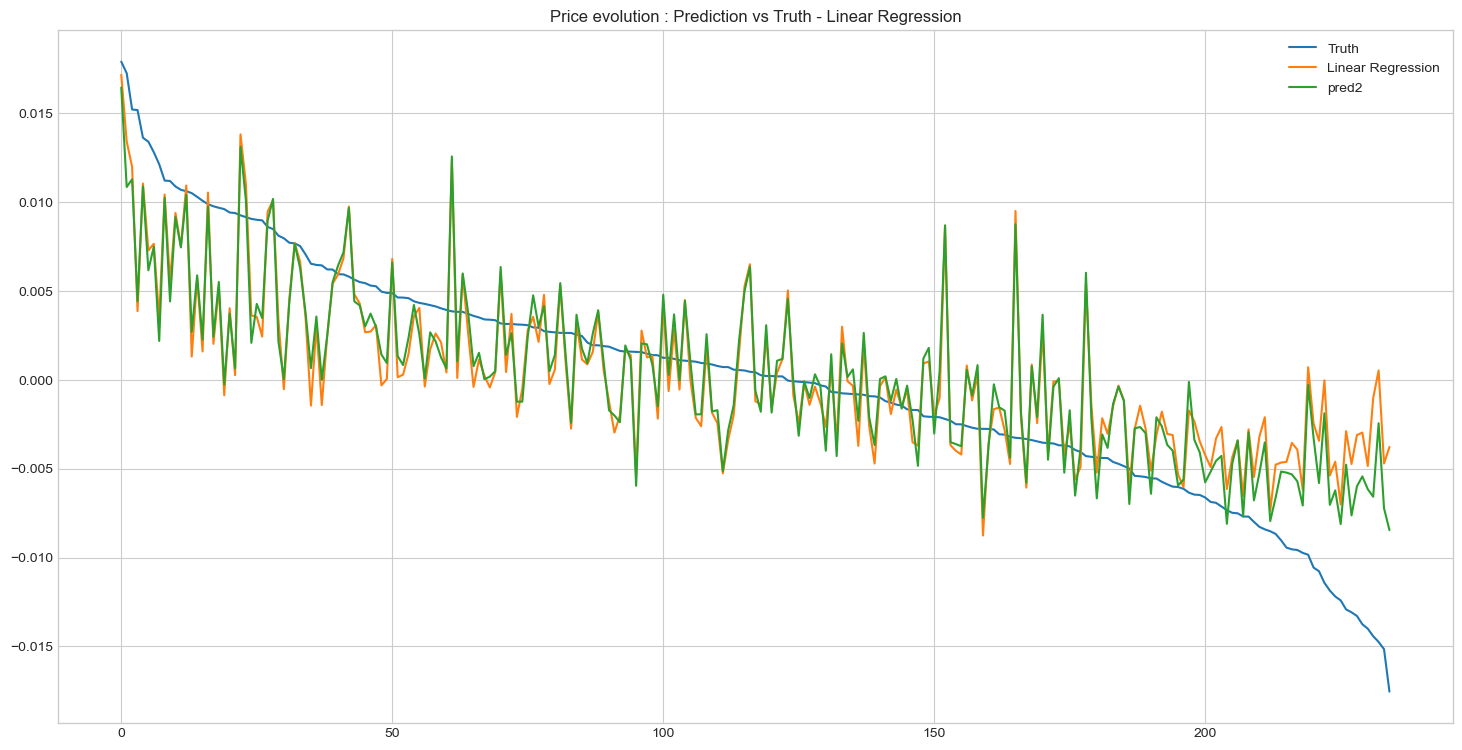

In [28]:
show_evolution2(predictions_lin, predictions_bgr, 'Linear Regression')